## Predicting Formula 1 Race Outcomes and Evaluating Betting Performance

### Index

1. **Problem Definition**
2. **Data Collection and Preprocessing**
3. **Exploratory Data Analysis (EDA)**
4. **Feature Engineering**
5. **Modeling Approaches**
   - 5.1. Predicting the Race Winner (Classification)
   - 5.2. Predicting Race Positions (Regression)
   - 5.3. Predicting Race Positions (Multiclass Classification)
6. **Model Evaluation and Comparison**
7. **Betting Odds Analysis**
   - 7.1. Collecting Betting Odds
   - 7.2. Simulating Betting Outcomes
   - 7.3. Evaluating Profitability of Predictions
8. **Insights and Conclusions**
9. **Future Work**


### EDA & Preprocessing

In [1]:
import numpy as np
import pandas as pd

In [2]:
circuits = pd.read_csv('data/circuits.csv')
constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
drivers = pd.read_csv('data/drivers.csv')
qualifying = pd.read_csv('data/qualifying.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')

In [3]:
print("Shape of circuits:", circuits.shape)
print("Shape of constructor_standings:", constructor_standings.shape)
print("Shape of constructors:", constructors.shape)
print("Shape of driver_standings:", driver_standings.shape)
print("Shape of drivers:", drivers.shape)
print("Shape of qualifying:", qualifying.shape)
print("Shape of races:", races.shape)
print("Shape of results:", results.shape)

Shape of circuits: (77, 9)
Shape of constructor_standings: (13271, 7)
Shape of constructors: (212, 5)
Shape of driver_standings: (34595, 7)
Shape of drivers: (859, 9)
Shape of qualifying: (10254, 9)
Shape of races: (1125, 18)
Shape of results: (26519, 18)


Key Observations
Datasets and Sizes:

Small datasets: circuits, constructors, drivers, status.
Medium datasets: constructor_results, constructor_standings, races, results, qualifying, sprint_results.
Large datasets: lap_times, pit_stops.
Columns with IDs:

raceId, driverId, constructorId are central identifiers linking multiple datasets.
Missing Data:

qualifying has missing values in q2 and q3.
races has placeholders like \N in session times.

Common Relationships:

races connects with circuits (via circuitId), results and qualifying (via raceId).
drivers and constructors connect with results (via driverId, constructorId).
lap_times and pit_stops detail race events (via raceId, driverId).

In [4]:
# Merge datasets using INNER JOINs with custom suffixes
merged_data = pd.merge(races, circuits, on="circuitId", how="inner", suffixes=('_races', '_circuits'))
merged_data = pd.merge(merged_data, results, on="raceId", how="inner", suffixes=('', '_results'))
merged_data = pd.merge(merged_data, drivers, on="driverId", how="inner", suffixes=('', '_drivers'))
merged_data = pd.merge(merged_data, constructors, on="constructorId", how="inner", suffixes=('', '_constructors'))
merged_data = pd.merge(merged_data, driver_standings, on=["raceId", "driverId"], how="inner", suffixes=('', '_driver_standings'))
merged_data = pd.merge(merged_data, constructor_standings, on=["raceId", "constructorId"], how="inner", suffixes=('', '_constructor_standings'))
merged_data = pd.merge(merged_data, qualifying, on=["raceId", "driverId"], how="inner", suffixes=('', '_qualifying'))


In [5]:
print(merged_data.shape)
merged_data.describe

(10011, 72)


<bound method NDFrame.describe of        raceId  year  round  circuitId                name_races        date  \
0           1  2009      1          1     Australian Grand Prix  2009-03-29   
1           1  2009      1          1     Australian Grand Prix  2009-03-29   
2           2  2009      2          2      Malaysian Grand Prix  2009-04-05   
3           2  2009      2          2      Malaysian Grand Prix  2009-04-05   
4           3  2009      3         17        Chinese Grand Prix  2009-04-19   
...       ...   ...    ...        ...                       ...         ...   
10006     944  2015     18         18      Brazilian Grand Prix  2015-11-15   
10007     943  2015     17         32        Mexican Grand Prix  2015-11-01   
10008     943  2015     17         32        Mexican Grand Prix  2015-11-01   
10009     942  2015     16         69  United States Grand Prix  2015-10-25   
10010     942  2015     16         69  United States Grand Prix  2015-10-25   

           time  

In [6]:
merged_data.isnull().sum()

raceId                  0
year                    0
round                   0
circuitId               0
name_races              0
                       ..
number_qualifying       0
position_qualifying     0
q1                      0
q2                     13
q3                     27
Length: 72, dtype: int64

veiem que tot i que posa que només hi ha 13 i 27 nuls respectivament hi ha molts valors que son \N i que pertant també son nuls. Començem per canviar \N per NaN

In [7]:
merged_data.replace('\\N', np.nan, inplace=True)

In [8]:
merged_data.isnull().sum()

raceId                    0
year                      0
round                     0
circuitId                 0
name_races                0
                       ... 
number_qualifying         0
position_qualifying       0
q1                      149
q2                     4364
q3                     6509
Length: 72, dtype: int64

Ara si veiem que hi ha molts nuls a q2 i q3. Understanding the Problem
q1: Represents all drivers with qualifying times (minimal missing values).
q2: Only available for the top 15 fastest drivers from q1.
q3: Only available for the top 10 fastest drivers from q2.
These missing values are not random but instead a result of the qualification rules. They carry information about the driver's performance and ranking. For example:

A missing value in q2 means the driver did not make it past q1.
A missing value in q3 means the driver did not make it past q2.

El format de classificació de 3 rondes es va introudir al 2006 i llavors només tindria sentit posar columens binàries sobre si van passar q1 i la q2 a partir del 2006. Per simplificar eliminaré les columnes q2 i q3

In [9]:
merged_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name_races', 'date', 'time',
       'url_races', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'circuitRef', 'name_circuits', 'location', 'country', 'lat', 'lng',
       'alt', 'url_circuits', 'resultId', 'driverId', 'constructorId',
       'number', 'grid', 'position', 'positionText', 'positionOrder', 'points',
       'laps', 'time_results', 'milliseconds', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef',
       'number_drivers', 'code', 'forename', 'surname', 'dob', 'nationality',
       'url', 'constructorRef', 'name', 'nationality_constructors',
       'url_constructors', 'driverStandingsId', 'points_driver_standings',
       'position_driver_standings', 'positionText_driver_standings', 'wins',
       'constructorStandingsId', 'points_constructor_standings',
       'position_constructor_standings'

In [10]:
# Columns to drop
columns_to_drop = [
    'driverId', 'constructorId', 'statusId', 'qualifyId', 'constructorResultsId', 'constructorStandingsId', 'driverStandingsId',
    'url_races', 'tiime', 'url_circuits', 'number', 'url_results', 'url', 'code', 'url_drivers', 'resultId',
    'name_circuits', 'location', 'lat', 'lng', 'alt', 'url_drivers', 'constructorStandingsId', 'time', 'driverRef',
    'number', 'code', 'url_constructors', 'url_driver_standings', 'positionText', 'positionOrder', 'position_qualifying',
    'time_results', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'number_drivers',
    'positionText_driver_standings', 'constructorId_qualifying', 'number_qualifying', 'position_qualifying',
    'positionText_constructor_standings', 'positionOrder_constructor_standings', 'points_constructor_standings',
    'wins_constructor_standings', 'positionText_constructor_standings', 'constructorRef', 'position_constructor_standings',
    'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'
]


# Lists of status IDs
driver_error_status_ids = [3, 4, 20, 28, 68, 73, 82, 89, 100, 104, 107, 130, 139]
constructor_error_status_ids = [
    5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37,
    38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 59, 60, 61, 63, 64, 65, 66,
    67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 83, 84, 86, 87, 91, 94, 95, 98, 99,
    101, 102, 103, 105, 106, 108, 109, 110, 121, 126, 129, 131, 132, 135, 140, 141
]
finished_status_ids = [
    1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 45, 50, 53, 55, 88,
    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123,
    124, 125, 127, 128, 133, 134
]

# Initialize columns with zeros
merged_data['driver_dnf'] = 0
merged_data['constructor_dnf'] = 0

# Set driver_dnf to 1 where statusId is a driver error
merged_data.loc[merged_data['statusId'].isin(driver_error_status_ids), 'driver_dnf'] = 1

# Set constructor_dnf to 1 where statusId is a constructor error
merged_data.loc[merged_data['statusId'].isin(constructor_error_status_ids), 'constructor_dnf'] = 1

# Ensure that drivers who finished the race have zeros in both columns
merged_data.loc[merged_data['statusId'].isin(finished_status_ids), ['driver_dnf', 'constructor_dnf']] = 0

# Drop the specified columns
merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')



In [11]:
merged_data.head()

,raceId,year,round,circuitId,name_races,date,circuitRef,country,grid,position,...,name,nationality_constructors,points_driver_standings,position_driver_standings,wins,q1,q2,q3,driver_dnf,constructor_dnf
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,Brawn,British,10.0,1,1,1:25.211,1:24.855,1:26.202,0,0
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,Brawn,British,8.0,2,0,1:25.006,1:24.783,1:26.505,0,0
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,Brawn,British,15.0,1,2,1:35.058,1:33.784,1:35.181,0,0
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,Brawn,British,10.0,2,0,1:34.681,1:34.387,1:35.651,0,0
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,Brawn,British,21.0,1,2,1:35.533,1:35.556,1:36.532,0,0


In [12]:
merged_data.rename(columns={
    'name_races': 'GP_name',
    'nationality': 'driver_nationality',
    'points_driver_standings': 'total_points',
    'position_driver_standings': 'championship_position',
    'name': 'constructor_name',
    'wins' : 'number_wins'
}, inplace = True)

In [13]:
merged_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'GP_name', 'date', 'circuitRef',
       'country', 'grid', 'position', 'points', 'laps', 'forename', 'surname',
       'dob', 'driver_nationality', 'constructor_name',
       'nationality_constructors', 'total_points', 'championship_position',
       'number_wins', 'q1', 'q2', 'q3', 'driver_dnf', 'constructor_dnf'],
      dtype='object')

In [14]:
# Combine 'forename' and 'surname' into a single column called 'driver_name'
merged_data['driver_name'] = merged_data['forename'] + ' ' + merged_data['surname']

# Drop the original 'forename' and 'surname' columns as they are no longer needed
merged_data = merged_data.drop(columns=['forename', 'surname'], errors='ignore')

#tranform the 'dob' and 'date' column to datetime
merged_data['dob'] = pd.to_datetime(merged_data['dob'])
merged_data['date'] = pd.to_datetime(merged_data['date'])
# Calculate the age of the driver at the time of the Grand Prix in days
merged_data['age_at_gp_in_days'] = (merged_data['date'] - merged_data['dob']).dt.days


# Display the first few rows to confirm the changes
merged_data.head()

,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,total_points,championship_position,number_wins,q1,q2,q3,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,10.0,1,1,1:25.211,1:24.855,1:26.202,0,0,Jenson Button,10662
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,8.0,2,0,1:25.006,1:24.783,1:26.505,0,0,Rubens Barrichello,13459
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,15.0,1,2,1:35.058,1:33.784,1:35.181,0,0,Jenson Button,10669
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,10.0,2,0,1:34.681,1:34.387,1:35.651,0,0,Rubens Barrichello,13466
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,21.0,1,2,1:35.533,1:35.556,1:36.532,0,0,Jenson Button,10683


In [15]:
nationality_to_country = {
    "German": "Germany",
    "Dutch": "Netherlands",
    "British": "UK",
    "Brazilian": "Brazil",
    "Finnish": "Finland",
    "French": "France",
    "Austrian": "Austria",
    "Italian": "Italy",
    "Japanese": "Japan",
    "Australian": "Australia",
    "Portuguese": "Portugal",
    "Monegasque": "Monaco",
    "Belgian": "Belgium",
    "Swiss": "Switzerland",
    "Danish": "Denmark",
    "Canadian": "Canada",
    "Argentine": "Argentina",
    "Spanish": "Spain",
    "Colombian": "Colombia",
    "Czech": "Czech Republic",
    "Malaysian": "Malaysia",
    "Irish": "Ireland",
    "Hungarian": "Hungary",
    "Indian": "India",
    "American": "USA",
    "Polish": "Poland",
    "Russian": "Russia",
    "Venezuelan": "Venezuela",
    "Mexican": "Mexico",
    "Swedish": "Sweden",
    "Indonesian": "Indonesia",
    "New Zealander": "New Zealand",
    "Thai": "Thailand",
}

In [16]:
# Map driver_nationality to driver_country using the nationality_to_country dictionary
merged_data['driver_country'] = merged_data['driver_nationality'].map(nationality_to_country)

merged_data['constructor_country'] = merged_data['nationality_constructors'].map(nationality_to_country)

# drop driver_nationality column
merged_data.drop(columns=['driver_nationality','nationality_constructors' ], inplace=True)

In [17]:
merged_data = merged_data.sort_values(by=['year', 'round'])

In [18]:
#we only consider from 2006 to 2024

merged_data = merged_data[merged_data['year'] >= 2006]
merged_data = merged_data[merged_data['year'] < 2024]

In [19]:
merged_data.to_csv('data/merged_data.csv', index=False)

### Step 1: Data Structure Analysis

In [20]:
# Step 1: Understand the Data Structure

# Display the shape of the dataset
dataset_shape = merged_data.shape

# List column names and their data types
column_info = merged_data.dtypes

# Sample unique values for each column
unique_values_sample = merged_data.nunique()

# Check for missing values in each column
missing_values = merged_data.isnull().sum()

# Compile the information into a summary table
data_overview = pd.DataFrame({
    "Data Type": column_info,
    "Unique Values": unique_values_sample,
    "Missing Values": missing_values,
    "Missing %": (missing_values / dataset_shape[0]) * 100
})


dataset_shape, data_overview


((7358, 26),
                             Data Type  Unique Values  Missing Values  \
 raceId                          int64            351               0   
 year                            int64             18               0   
 round                           int64             22               0   
 circuitId                       int64             38               0   
 GP_name                        object             41               0   
 date                   datetime64[ns]            351               0   
 circuitRef                     object             38               0   
 country                        object             30               0   
 grid                            int64             25               0   
 position                       object             24            1288   
 points                        float64             29               0   
 laps                            int64             80               0   
 dob                    datetime64[ns]

### Observations:

- Dataset Size: The dataset contains 8,131 rows and 20 columns.
- Column Overview: Columns include a mix of numerical (e.g., grid, laps), categorical (e.g., GP_name, position), and datetime (e.g., date, dob) types.
- Unique Values: Several columns, such as driver_name and constructor_name, have high cardinality, indicating diversity in data points.
- Missing Data: There are no missing values in the dataset.

### Step 2: Summary Statistics

In [21]:
# Step 2: Summary Statistics

# Generate descriptive statistics for numeric columns
numeric_summary = merged_data.describe()

# Display statistics for categorical columns
categorical_summary = merged_data.select_dtypes(include=['object']).describe()

numeric_summary, categorical_summary


(            raceId         year        round    circuitId         grid  \
 count  7358.000000  7358.000000  7358.000000  7358.000000  7358.000000   
 mean    754.361919  2014.669747    10.343708    21.150992    10.915194   
 std     390.258572     5.137255     5.710279    22.285381     6.217011   
 min       1.000000  2006.000000     1.000000     1.000000     0.000000   
 25%     354.000000  2010.000000     5.000000     6.000000     6.000000   
 50%     928.000000  2015.000000    10.000000    14.000000    11.000000   
 75%    1021.000000  2019.000000    15.000000    22.000000    16.000000   
 max    1120.000000  2023.000000    22.000000    80.000000    24.000000   
 
             points         laps  total_points  championship_position  \
 count  7358.000000  7358.000000   7358.000000            7358.000000   
 mean      4.237836    53.016309     44.435376              11.240283   
 std       6.635527    18.243792     68.064282               6.378902   
 min       0.000000     0.00000


### Key Insights:

- Numerical Summary:
    - Columns like grid and laps have wide ranges, which suggests varying conditions across races.
    - Some variables like total_points and championship_position could potentially be strong predictors for the winner.

- Categorical Summary:
    - GP_name has 31 unique values, which corresponds to different Grand Prix events.
    - driver_name has 156 unique entries, reflecting a diverse set of participants.
    - Variables such as q1, q2, and q3 include significant amounts of non-informative data (\N), which may require cleaning or imputation.

In [22]:
# Convert 'position' column to numeric, forcing errors to NaN
merged_data['position'] = pd.to_numeric(merged_data['position'], errors='coerce')

# Assign a distinct position value for DNFs based on the maximum position in each race
merged_data['position'] = merged_data.groupby('raceId')['position'].transform(lambda x: x.fillna(x.max() + 1)).astype(int)

# Display the updated dataset structure and a sample to confirm changes
updated_sample = merged_data[['raceId', 'position']].head()
print(updated_sample)


      raceId  position
54        53         4
55        53        15
347       53         1
1002      53         7
1003      53         6


In [23]:
# Step 2: Add a `winner` column
# Create a new column where 1 indicates the driver who finished first, 0 otherwise
merged_data['winner'] = (merged_data['position'] == 1).astype(int)

# Display the updated dataset structure and a sample to confirm changes
updated_sample = merged_data[['raceId', 'position', 'winner']].head()

updated_sample

,raceId,position,winner
54,53,4,0
55,53,15,0
347,53,1,1
1002,53,7,0
1003,53,6,0


In [24]:
missing_values = merged_data.isnull().sum()
missing_values

raceId                      0
year                        0
round                       0
circuitId                   0
GP_name                     0
date                        0
circuitRef                  0
country                     0
grid                        0
position                    0
points                      0
laps                        0
dob                         0
constructor_name            0
total_points                0
championship_position       0
number_wins                 0
q1                         71
q2                       1997
q3                       3975
driver_dnf                  0
constructor_dnf             0
driver_name                 0
age_at_gp_in_days           0
driver_country             44
constructor_country         0
winner                      0
dtype: int64

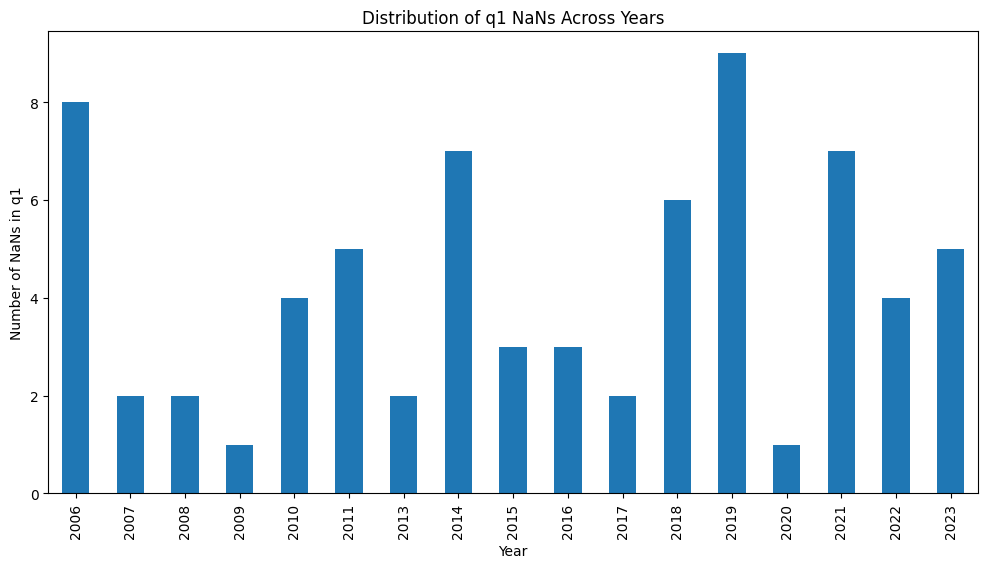

In [25]:
import matplotlib.pyplot as plt

# Count the number of NaNs in 'q1' for each year
q1_nans_per_year = merged_data[merged_data['q1'].isna()].groupby('year').size()

# Plot the results
plt.figure(figsize=(12, 6))
q1_nans_per_year.plot(kind='bar')
plt.title('Distribution of q1 NaNs Across Years')
plt.xlabel('Year')
plt.ylabel('Number of NaNs in q1')
plt.show()

veiem que els nuls estan distribuits al llarg dels anys. després d'analitzar una mica el dataset me n'he adonat que els nuls a q1 són degut a problemes mecanics o accidents dels pilots durant la classificació que fa que surtin des del pit lane (grid == 0), que després ho canviaré al darrera posició en comptes de 0, ja que sinó afecta a la correlació de les variables. 

Per tractar els nuls de q1 he fet el seguent: 

first convert q1 column to seconds. then input the missing values with the mean of the q1 for that particular race

In [26]:
def convert_to_seconds(time_str):
    if pd.isna(time_str) or time_str in ['0', '', 'N/A']:
        return np.nan
    try:
        if ':' in time_str:
            minutes, seconds = time_str.split(':')
            return int(minutes) * 60 + float(seconds)
        else:
            return float(time_str)
    except (ValueError, TypeError):
        return np.nan

In [27]:
# Count remaining NaNs in q1_seconds
merged_data['q1_seconds'] = merged_data['q1'].apply(convert_to_seconds)
merged_data['q2_seconds'] = merged_data['q2'].apply(convert_to_seconds)
merged_data['q3_seconds'] = merged_data['q3'].apply(convert_to_seconds)


num_nans = merged_data['q1_seconds'].isna().sum()
print(f"Number of NaNs in q1_seconds: {num_nans}")

num_nans = merged_data['q2_seconds'].isna().sum()
print(f"Number of NaNs in q2_seconds: {num_nans}")

num_nans = merged_data['q3_seconds'].isna().sum()
print(f"Number of NaNs in q3_seconds: {num_nans}")


Number of NaNs in q1_seconds: 71
Number of NaNs in q2_seconds: 1997
Number of NaNs in q3_seconds: 3975


In [28]:
# Calculate mean q1_seconds per race
mean_q1_per_race = merged_data.groupby('raceId')['q1_seconds'].transform('mean')

# Impute missing q1_seconds with race mean
merged_data['q1_seconds'] = merged_data['q1_seconds'].fillna(mean_q1_per_race)

# Calculate mean q2_seconds per race + penalty for not passing Q1
mean_q2_per_race = merged_data.groupby('raceId')['q2_seconds'].transform('mean') + 3

# Impute missing q2_seconds with race mean
merged_data['q2_seconds'] = merged_data['q2_seconds'].fillna(mean_q2_per_race)


# Calculate mean q2_seconds per race + penalty for not passing Q2
mean_q3_per_race = merged_data.groupby('raceId')['q2_seconds'].transform('mean') + 5

# Impute missing q2_seconds with race mean
merged_data['q3_seconds'] = merged_data['q2_seconds'].fillna(mean_q3_per_race)



In [29]:
# Count remaining NaNs in q1_seconds
num_nans = merged_data['q1_seconds'].isna().sum()
print(f"Number of NaNs in q1_seconds after reapplying the function: {num_nans}")

num_nans = merged_data['q2_seconds'].isna().sum()
print(f"Number of NaNs in q2_seconds after reapplying the function: {num_nans}")

num_nans = merged_data['q3_seconds'].isna().sum()
print(f"Number of NaNs in q3_seconds after reapplying the function: {num_nans}")

Number of NaNs in q1_seconds after reapplying the function: 0
Number of NaNs in q2_seconds after reapplying the function: 0
Number of NaNs in q3_seconds after reapplying the function: 0


In [30]:
# Display the first few rows to confirm the changes
merged_data.head()

,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days,driver_country,constructor_country,winner,q1_seconds,q2_seconds,q3_seconds
54,53,2006,1,3,Bahrain Grand Prix,2006-03-12,bahrain,Bahrain,3,4,...,0,0,Jenson Button,9549,UK,Japan,0,92.603,92.025,92.025
55,53,2006,1,3,Bahrain Grand Prix,2006-03-12,bahrain,Bahrain,6,15,...,0,0,Rubens Barrichello,12346,Brazil,Japan,0,93.922,92.322,92.322
347,53,2006,1,3,Bahrain Grand Prix,2006-03-12,bahrain,Bahrain,4,1,...,0,0,Fernando Alonso,8992,Spain,France,1,92.433,91.215,91.215
1002,53,2006,1,3,Bahrain Grand Prix,2006-03-12,bahrain,Bahrain,12,7,...,0,0,Nico Rosberg,7563,Germany,UK,0,92.945,92.620,92.620
1003,53,2006,1,3,Bahrain Grand Prix,2006-03-12,bahrain,Bahrain,7,6,...,0,0,Mark Webber,10789,Australia,UK,0,93.454,92.309,92.309


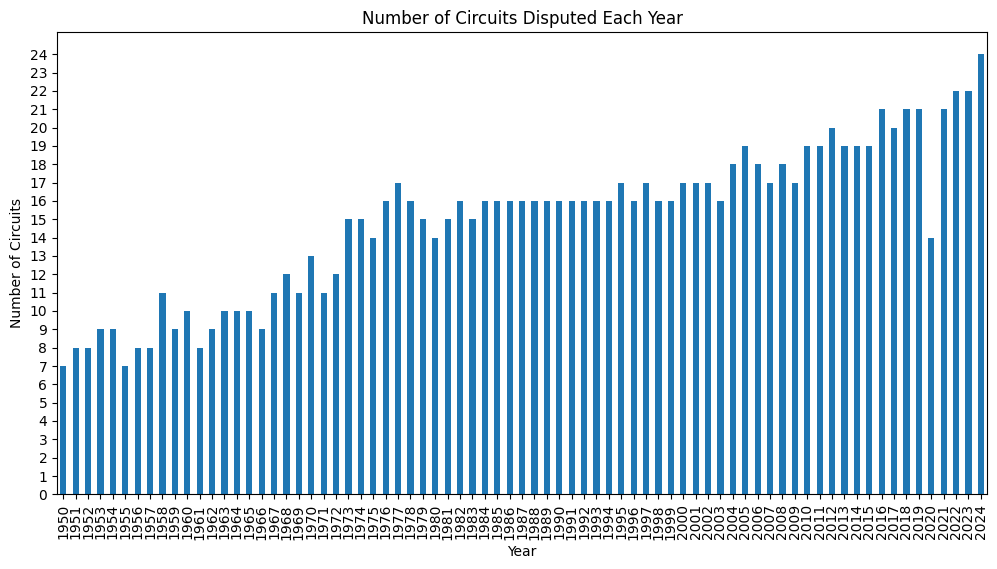

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and count the number of unique circuits
circuits_per_year = races.groupby('year')['circuitId'].nunique()

# Plot the results
plt.figure(figsize=(12, 6))
circuits_per_year.plot(kind='bar')
plt.title('Number of Circuits Disputed Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Circuits')
plt.yticks(range(0, int(circuits_per_year.max()) + 1))  # Set y-axis to integer values
plt.show()

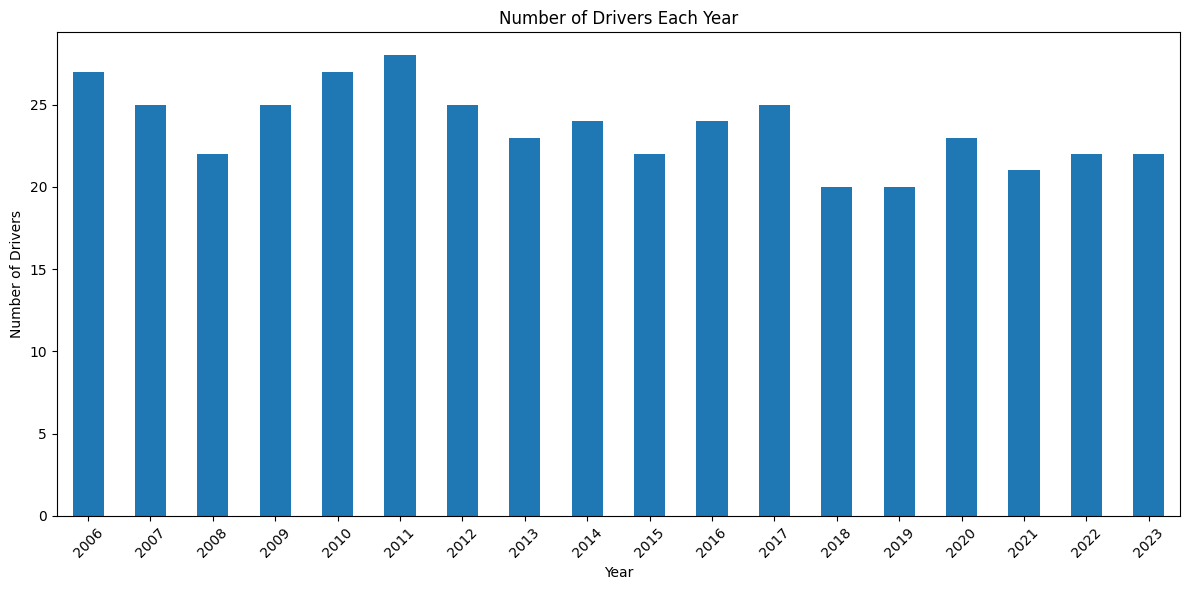

In [32]:
import matplotlib.pyplot as plt

# Group by year and count the number of unique drivers
drivers_per_year = merged_data.groupby('year')['driver_name'].nunique()

# Plot the results
plt.figure(figsize=(12, 6))
drivers_per_year.plot(kind='bar')
plt.title('Number of Drivers Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Drivers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
import matplotlib.pyplot as plt

def plot_wins_driver(results, threshold=1):
    # Your existing data manipulation steps
    winners = results[results['positionOrder'] == 1].merge(races, on='raceId')
    wins_per_driver = winners.groupby(['driverId', 'year']).size().unstack(fill_value=0)

    # Calculate total wins per driver
    total_wins_per_driver = wins_per_driver.sum(axis=1)

    # Merge with drivers to get surnames
    total_wins_per_driver = total_wins_per_driver.reset_index().merge(drivers[['driverId', 'surname']], on='driverId')

    # Filter out drivers with 0 wins
    total_wins_per_driver = total_wins_per_driver[total_wins_per_driver[0] > threshold]

    # Plot the results
    plt.figure(figsize=(15, 6))  # Increase figure size for better spacing
    ax = total_wins_per_driver.set_index('surname')[0].sort_values(ascending=False).plot(kind='bar', color='blue')

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right
    plt.title('Total Wins Per Driver')
    plt.xlabel('Driver Surname')
    plt.ylabel('Number of Wins')
    plt.grid(axis='y')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

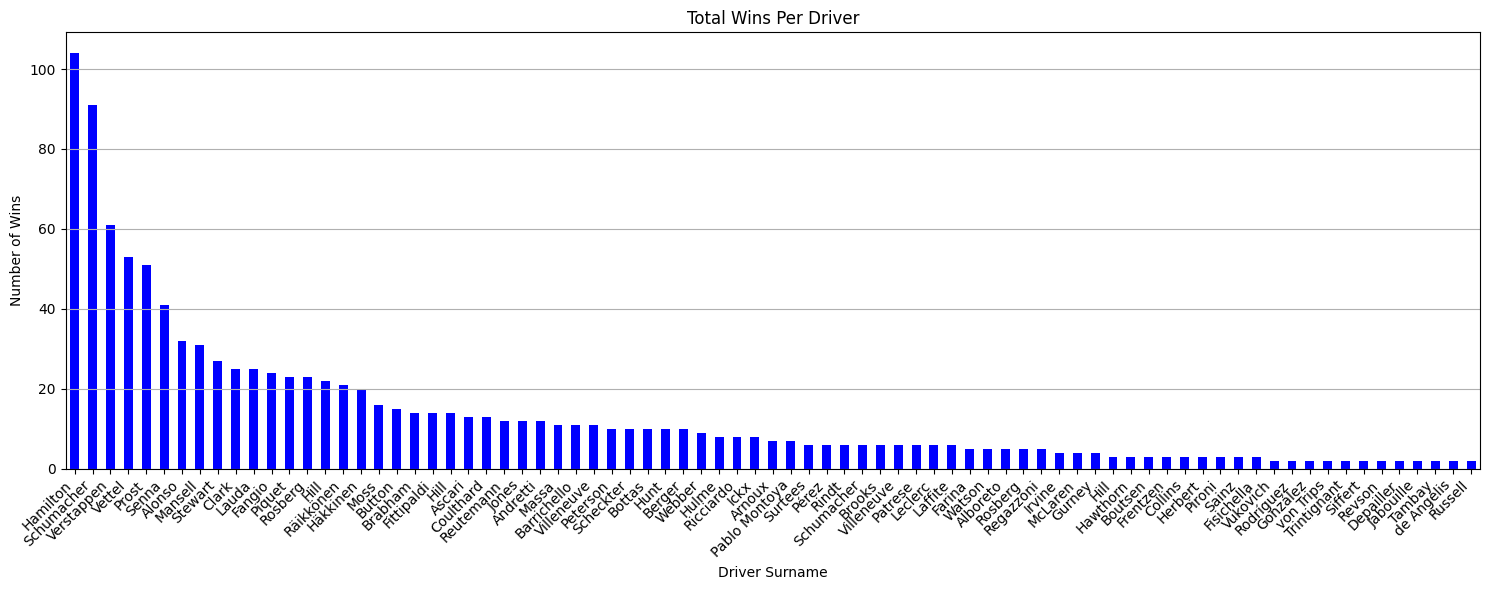

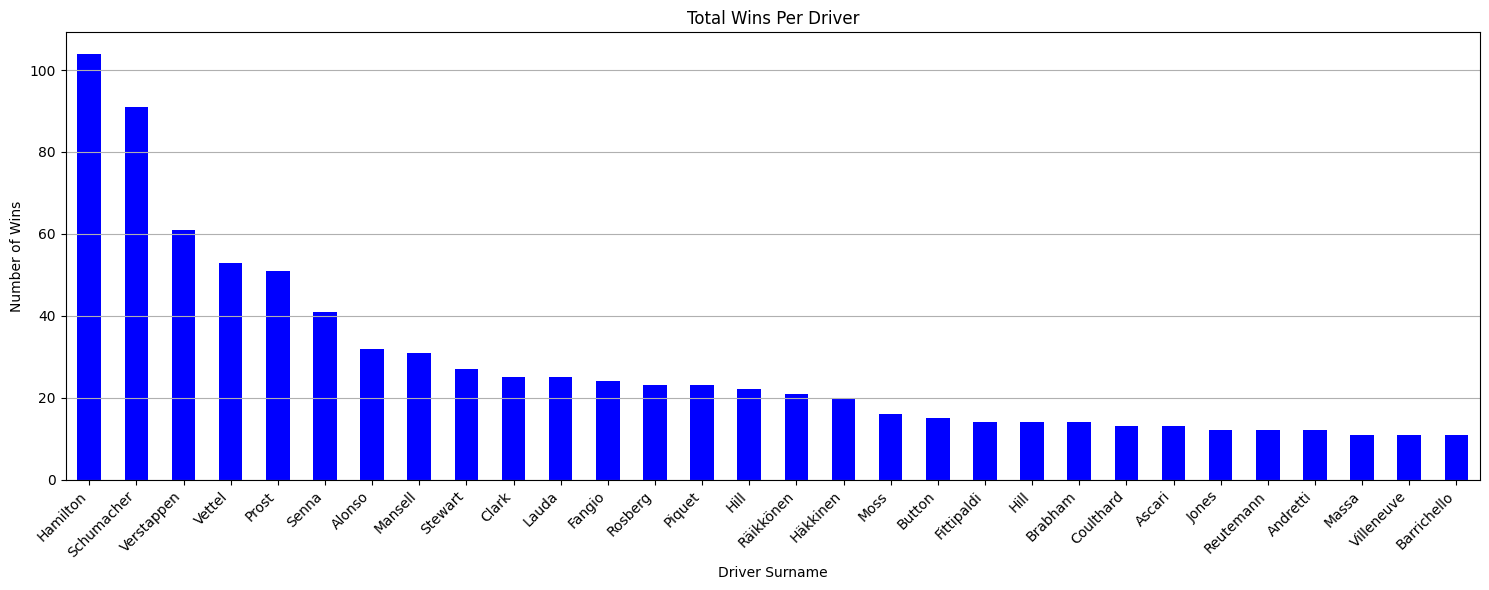

In [34]:
plot_wins_driver(results)
plot_wins_driver(results, threshold=10)

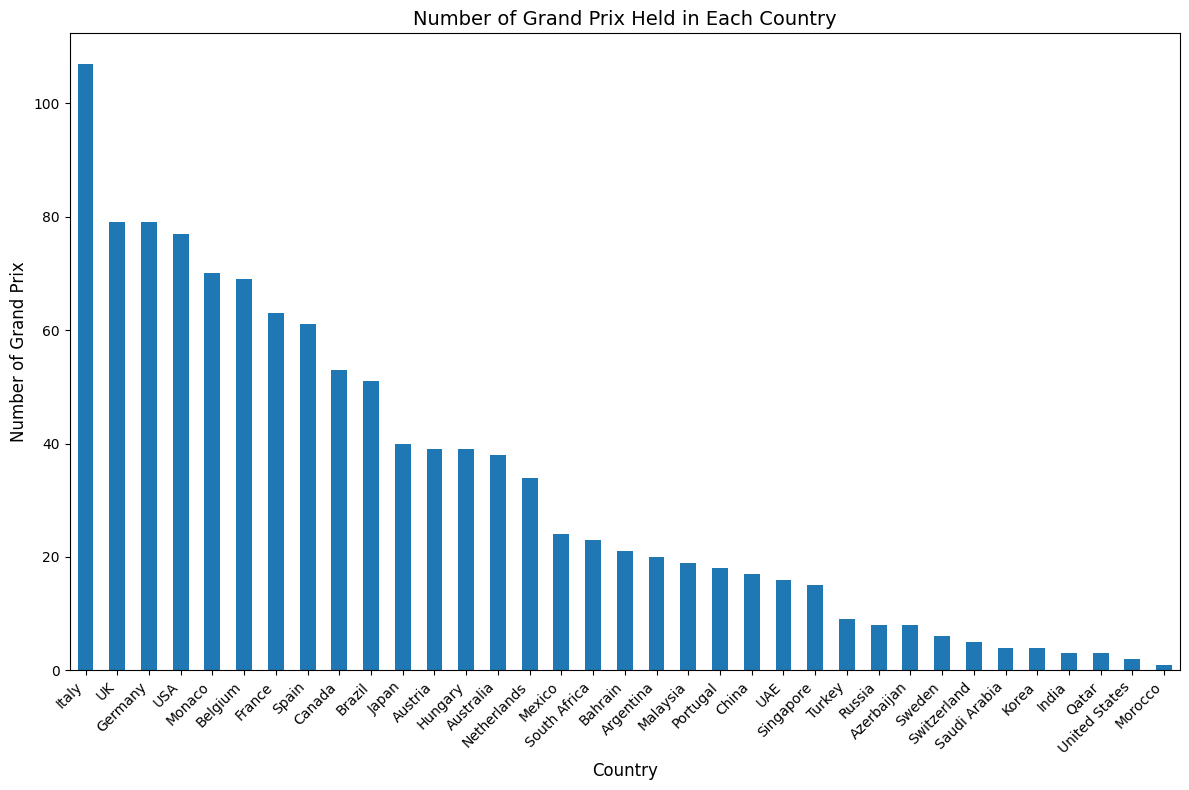

In [35]:
merged_df = pd.merge(races, circuits, left_on='circuitId', right_on='circuitId')
gp_by_country = merged_df['country'].value_counts()

# Plot the results
plt.figure(figsize=(12, 8))
gp_by_country.plot(kind='bar')
plt.title('Number of Grand Prix Held in Each Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Grand Prix', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

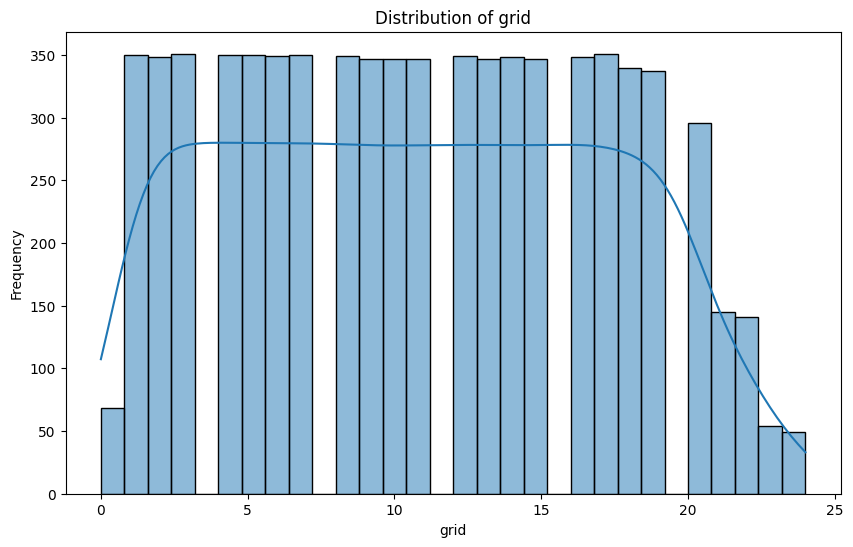

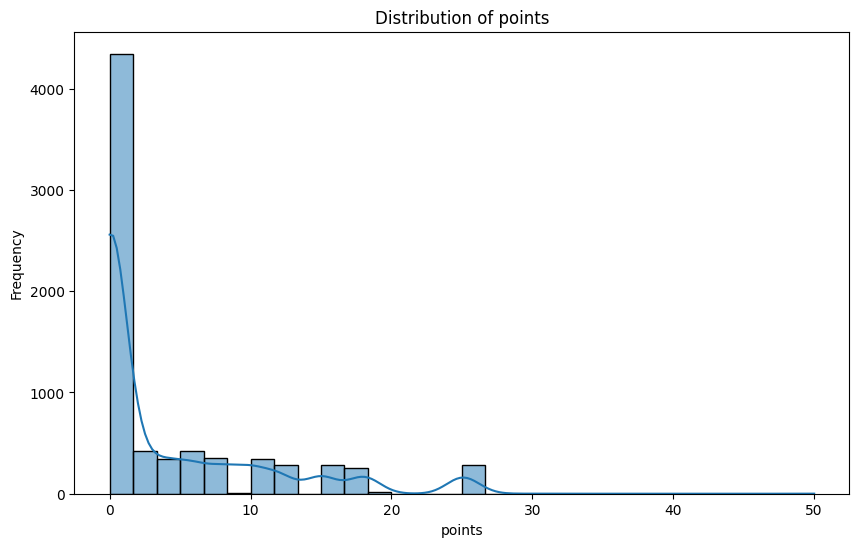

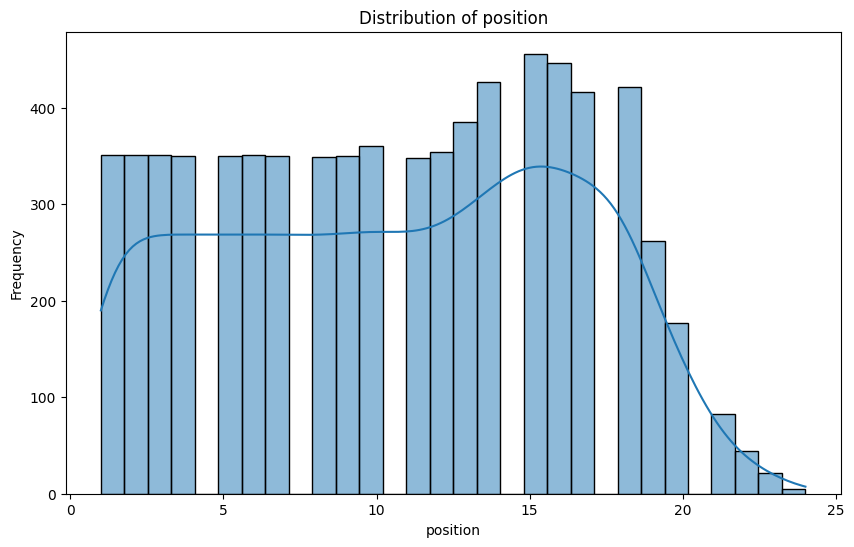

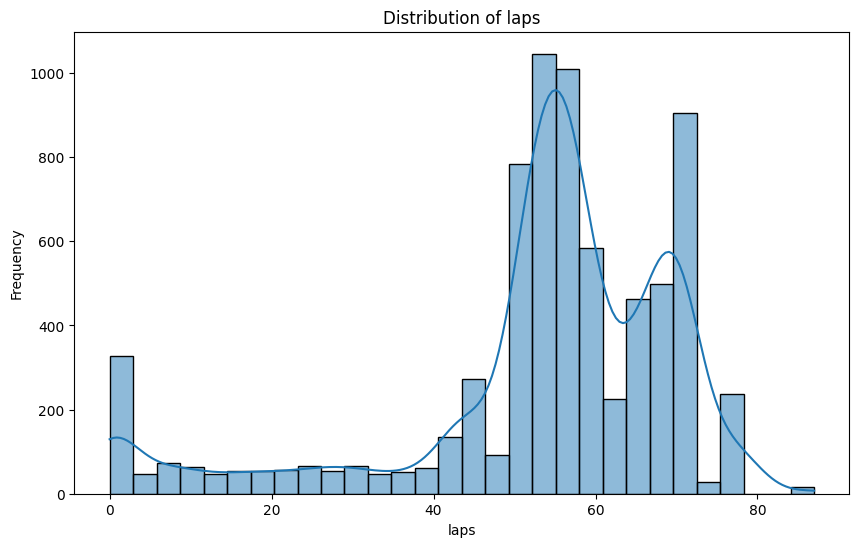

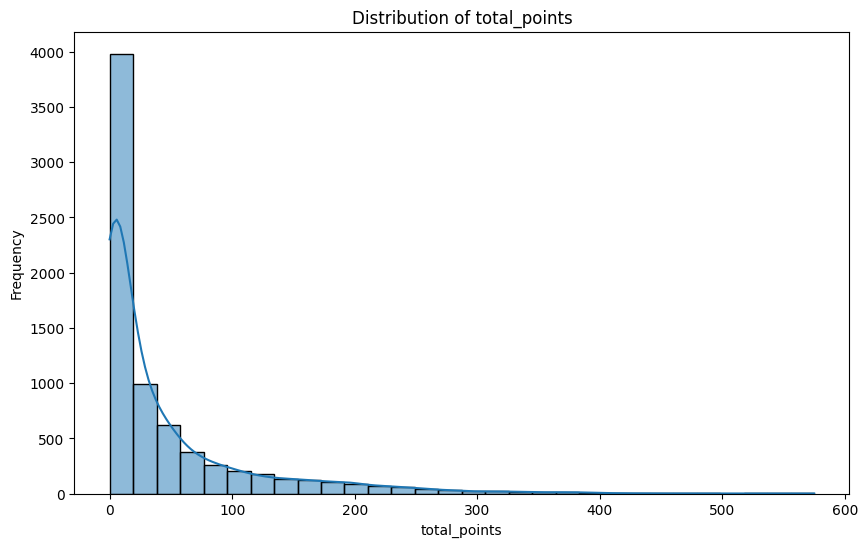

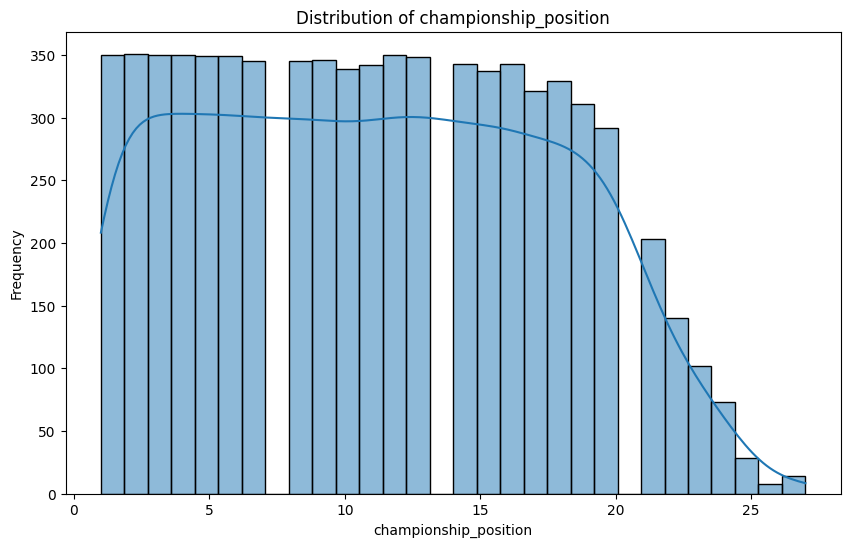

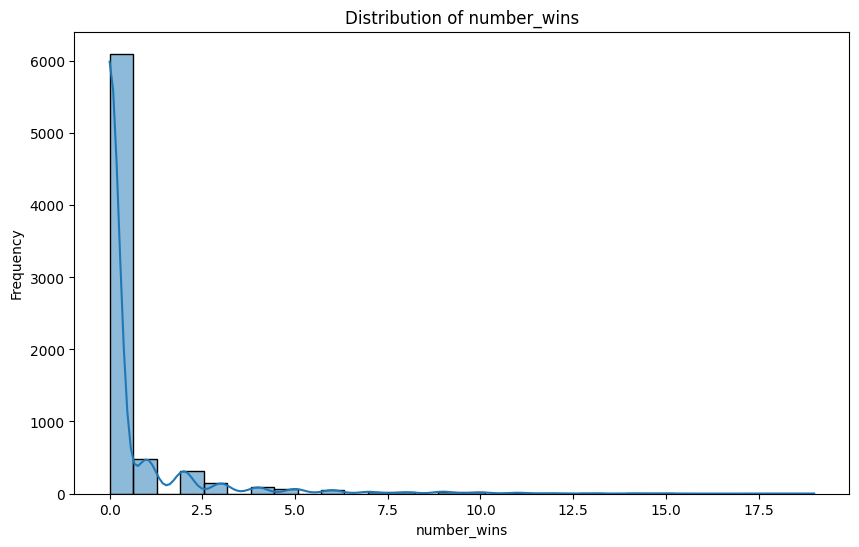

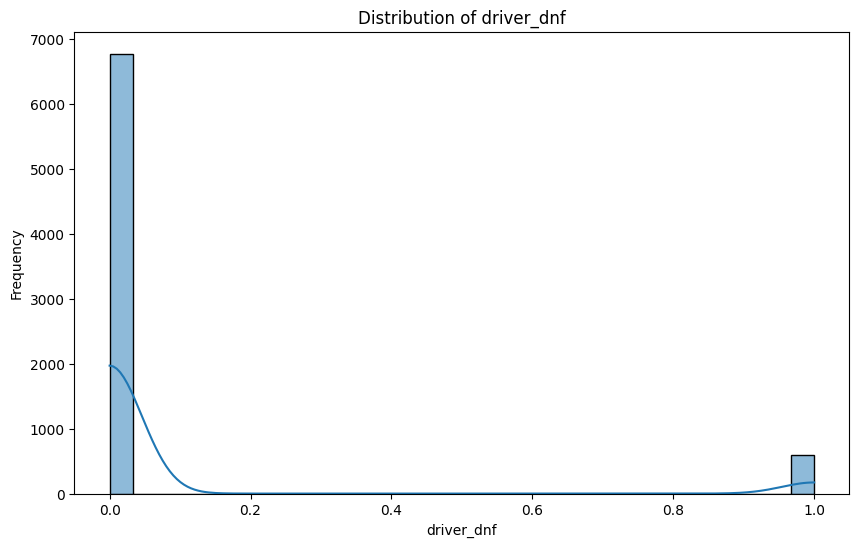

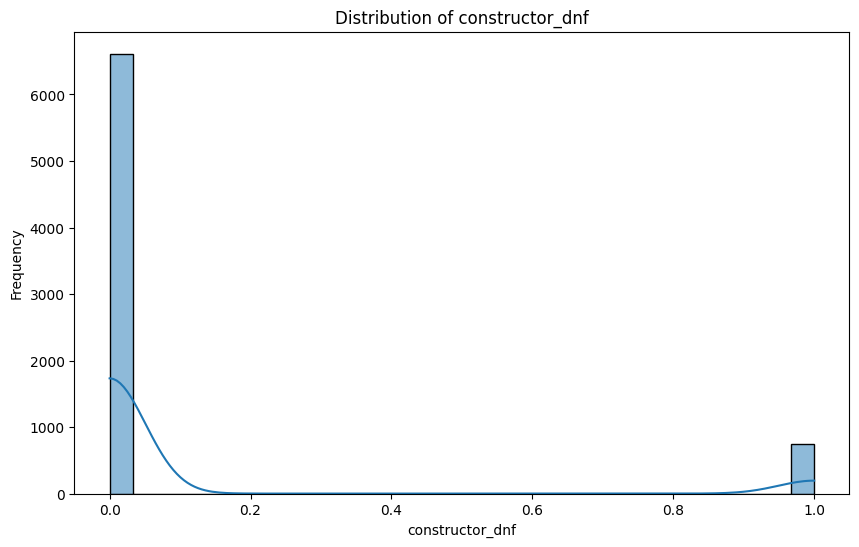

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical columns to plot
numerical_columns = ['grid', 'points', 'position', 'laps', 'total_points', 'championship_position', 'number_wins', 'driver_dnf', 'constructor_dnf']

# Plot histograms and KDEs for numerical variables
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

C:\Users\joelc\AppData\Local\Temp\ipykernel_10428\2968168162.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data.corr()


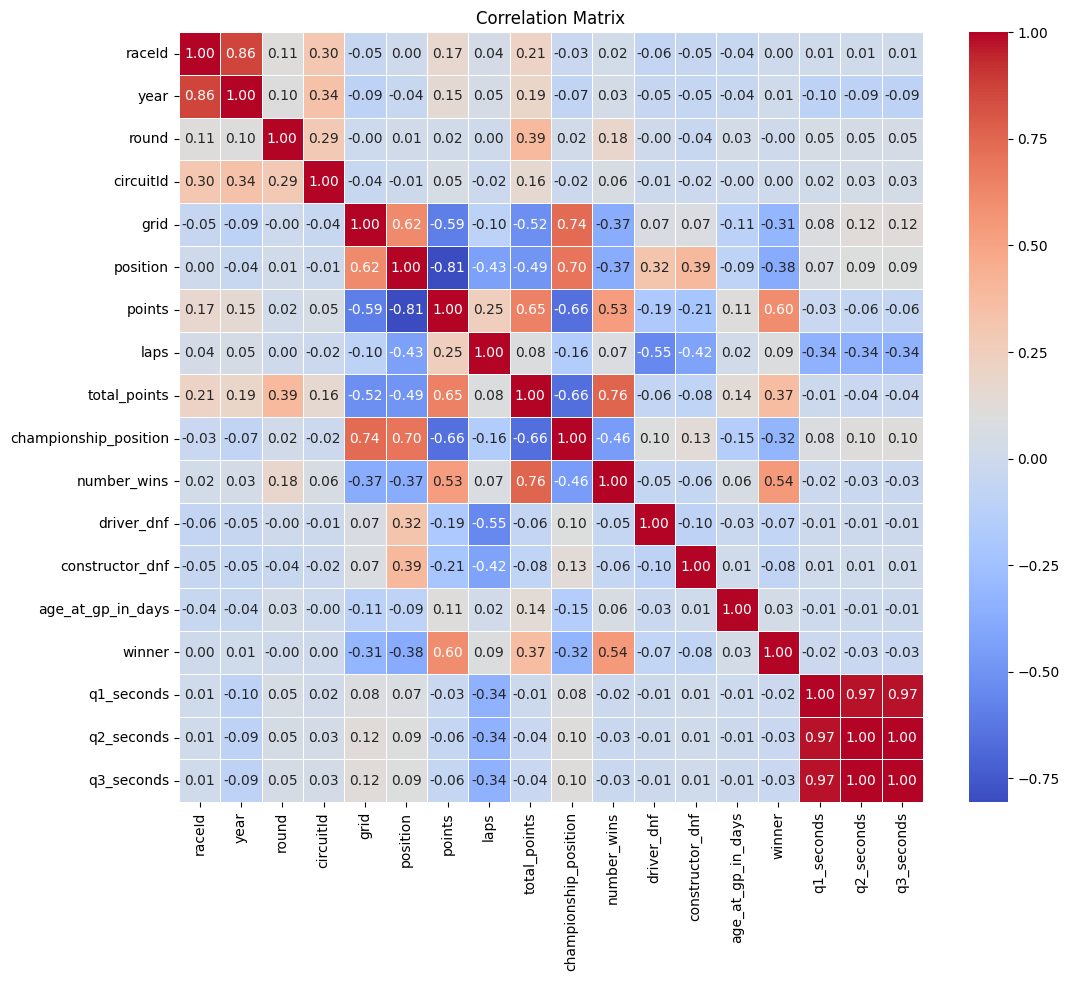

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Explore correlations between numerical variables
correlation_matrix = merged_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

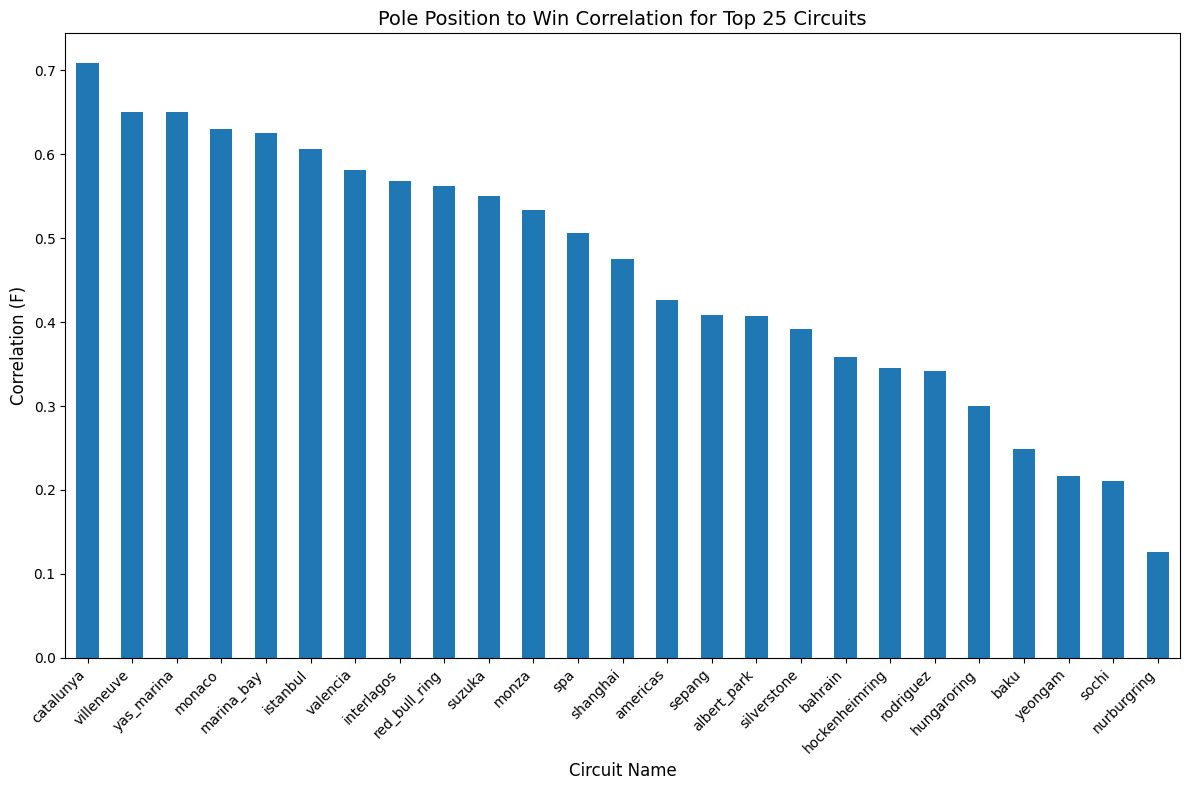

In [38]:
# Identify the 25 most popular circuits based on the number of races
top_circuits = merged_data['circuitId'].value_counts().head(25).index

# Filter the data for these circuits
filtered_data = merged_data[merged_data['circuitId'].isin(top_circuits)]

# Recalculate the correlation for these circuits
correlation_by_circuit = filtered_data.groupby('circuitId').apply(
    lambda x: x['grid'].eq(1).astype(int).corr(x['position'].eq(1).astype(int))
).sort_values(ascending=False)

# Get circuit names from the circuits data
circuit_names = circuits.set_index('circuitId')['circuitRef']

# Map circuit IDs to names for the x-axis
correlation_by_circuit.index = correlation_by_circuit.index.map(circuit_names)

# Plotting the correlation for the 15 most popular circuits
plt.figure(figsize=(12, 8))
correlation_by_circuit.plot(kind='bar')
plt.title('Pole Position to Win Correlation for Top 25 Circuits', fontsize=14)
plt.xlabel('Circuit Name', fontsize=12)
plt.ylabel('Correlation (F)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


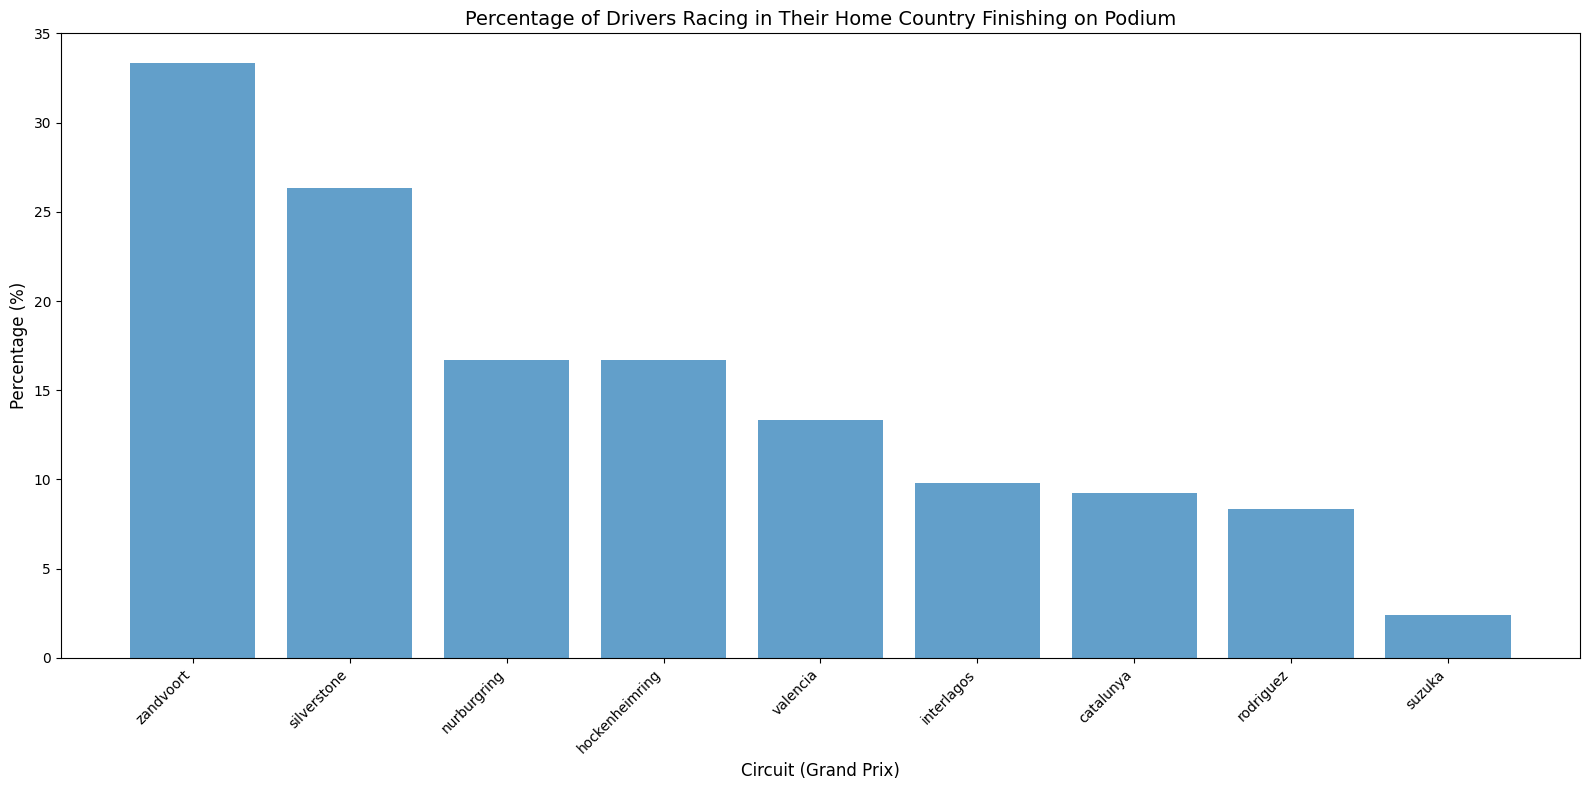

In [39]:
# Create a copy of cleaned_data
cleaned_data_df = merged_data.copy()


# Step 3: Add a column to indicate podium finishes
cleaned_data_df["on_podium"] = cleaned_data_df["position"].isin([1, 2, 3]).astype(int)

# Step 4: Calculate the percentage of podium finishes for drivers in their home country
podium_data = cleaned_data_df[cleaned_data_df["on_podium"] == 1]  # Filter podium data

# Group by circuitId and calculate the percentage of podium finishes for drivers in their home country
podium_home_circuit = (
    podium_data.apply(lambda x: x["country"] == x["driver_country"], axis=1)
    .groupby(podium_data["circuitId"])
    .mean()
    * 100
).sort_values(ascending=False)

# Merge with circuit information to get circuit names and countries
circuits_info = cleaned_data_df[["circuitId", "country", "circuitRef"]].drop_duplicates()
podium_home_circuit = podium_home_circuit.reset_index(name="percentage")
podium_home_circuit = podium_home_circuit.merge(circuits_info, on="circuitId", how="left")

# Filter to keep only circuits with percentage > 0
podium_home_circuit = podium_home_circuit[podium_home_circuit["percentage"] > 0]

# Sort by percentage and keep only necessary columns
podium_home_circuit = podium_home_circuit.sort_values(by="percentage", ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
plt.bar(
    podium_home_circuit["circuitRef"], podium_home_circuit["percentage"], alpha=0.7
)
plt.title("Percentage of Drivers Racing in Their Home Country Finishing on Podium", fontsize=14)
plt.xlabel("Circuit (Grand Prix)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



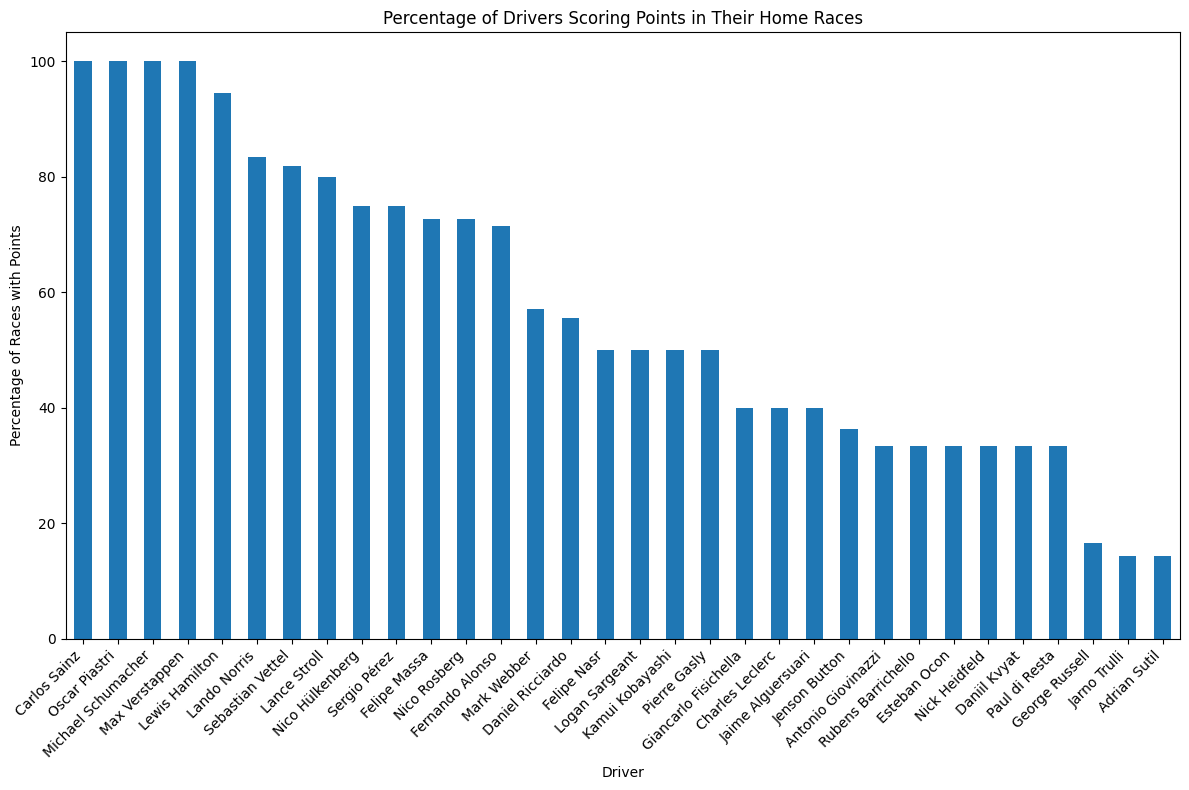

In [40]:
import matplotlib.pyplot as plt

# Filter data for drivers racing in their home country
home_race_data = cleaned_data_df[cleaned_data_df['country'] == cleaned_data_df['driver_country']]

# Calculate the percentage of races where drivers scored points in their home country
points_in_home_race = home_race_data[home_race_data['points'] > 0].groupby('driver_name').size()
total_home_races = home_race_data.groupby('driver_name').size()
points_percentage_home_race = (points_in_home_race / total_home_races) * 100

# Filter out drivers with 0% points
points_percentage_home_race = points_percentage_home_race[points_percentage_home_race > 0]

# Sort the results in descending order
points_percentage_home_race = points_percentage_home_race.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
points_percentage_home_race.plot(kind='bar')
plt.title('Percentage of Drivers Scoring Points in Their Home Races')
plt.xlabel('Driver')
plt.ylabel('Percentage of Races with Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

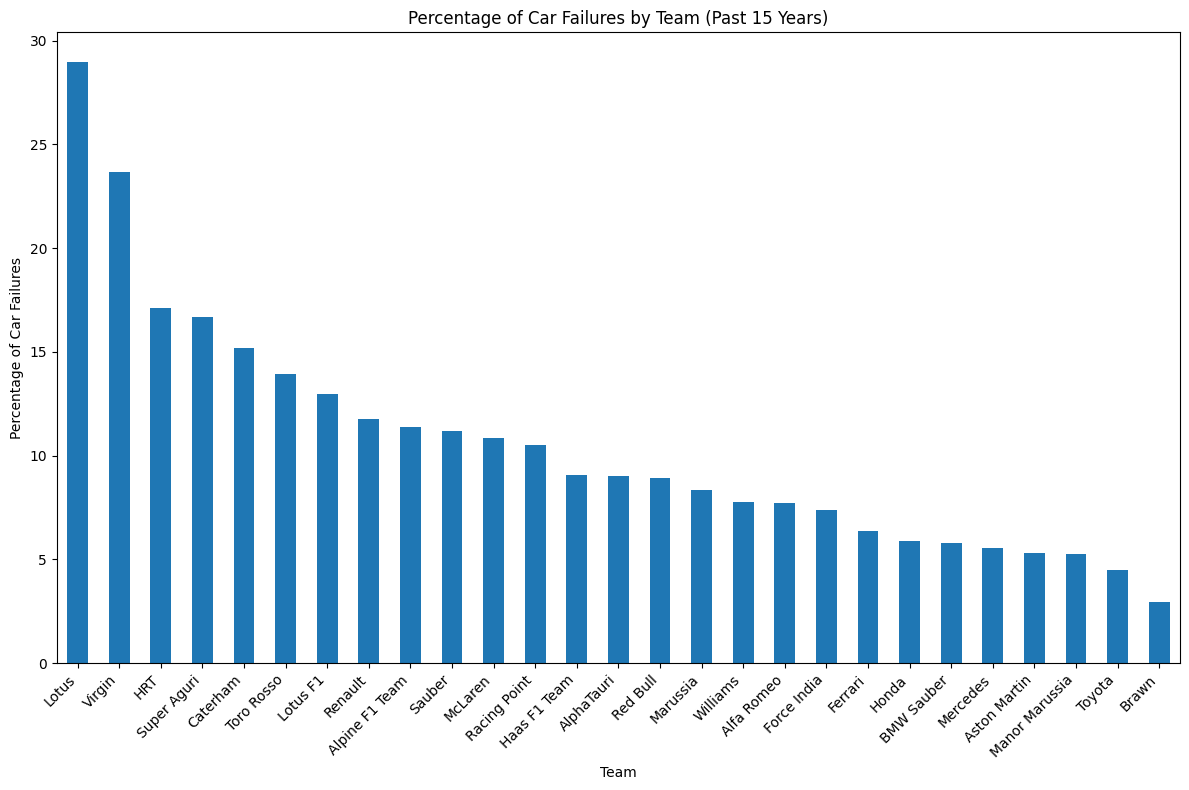

In [41]:
import matplotlib.pyplot as plt

# Filter data for the past 15 years
recent_years = merged_data[merged_data['year'] >= (merged_data['year'].max() - 15)]

# Calculate the total number of races for each team in the past 15 years
total_races_by_team_recent = recent_years['constructor_name'].value_counts()

# Calculate the number of failures for each team in the past 15 years
failures_by_team_recent = recent_years[recent_years['constructor_dnf'] == 1]['constructor_name'].value_counts()

# Calculate the percentage of failures
percentage_failures_by_team_recent = (failures_by_team_recent / total_races_by_team_recent) * 100

# Sort the results in descending order
percentage_failures_by_team_recent = percentage_failures_by_team_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_failures_by_team_recent.plot(kind='bar')
plt.title('Percentage of Car Failures by Team (Past 15 Years)')
plt.xlabel('Team')
plt.ylabel('Percentage of Car Failures')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

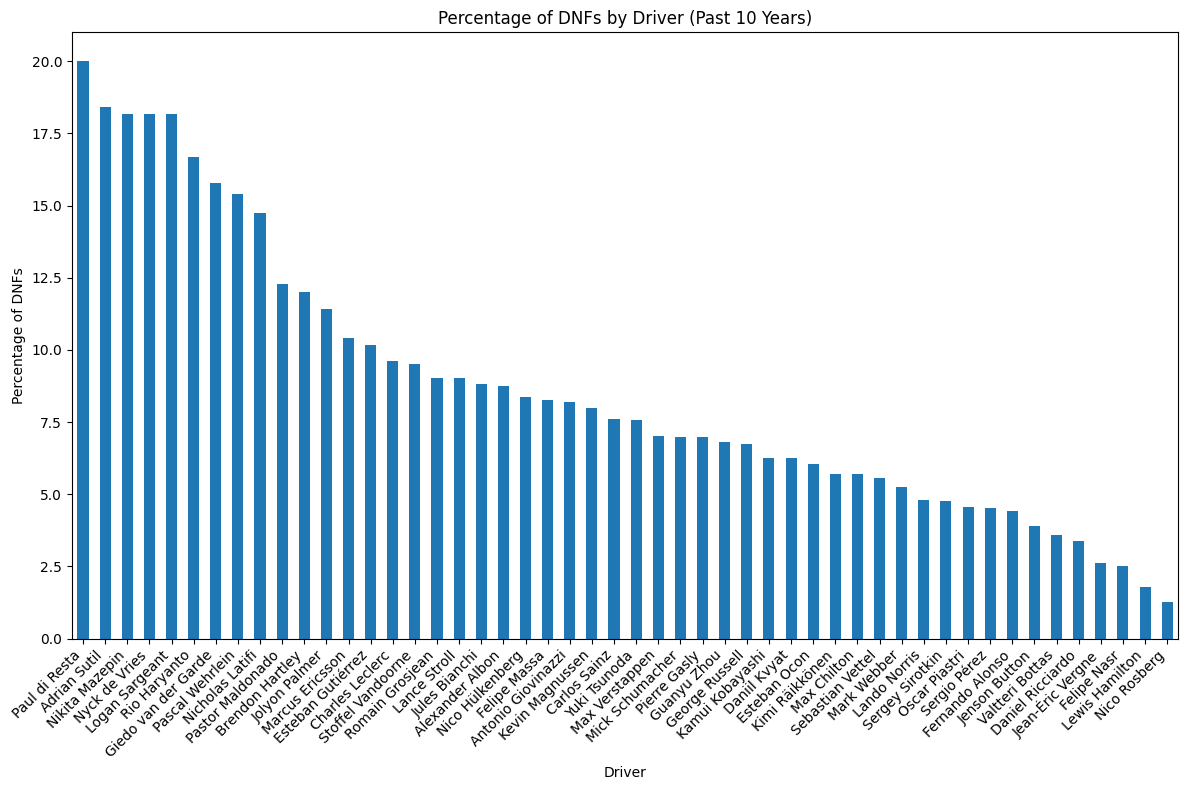

In [42]:
import matplotlib.pyplot as plt

# Filter data for the past 10 years
recent_years = merged_data[merged_data['year'] >= (merged_data['year'].max() - 10)]

# Calculate the total number of races for each driver in the past 10 years
total_races_by_driver_recent = recent_years['driver_name'].value_counts()

# Calculate the number of DNFs for each driver in the past 10 years
dnfs_by_driver_recent = recent_years[recent_years['driver_dnf'] == 1]['driver_name'].value_counts()

# Calculate the percentage of DNFs
percentage_dnfs_by_driver_recent = (dnfs_by_driver_recent / total_races_by_driver_recent) * 100

# Exclude drivers with 0 DNFs
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent[percentage_dnfs_by_driver_recent > 0]

# Sort the results in descending order
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_dnfs_by_driver_recent.plot(kind='bar')
plt.title('Percentage of DNFs by Driver (Past 10 Years)')
plt.xlabel('Driver')
plt.ylabel('Percentage of DNFs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\joelc\AppData\Local\Temp\ipykernel_10428\3859285042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25


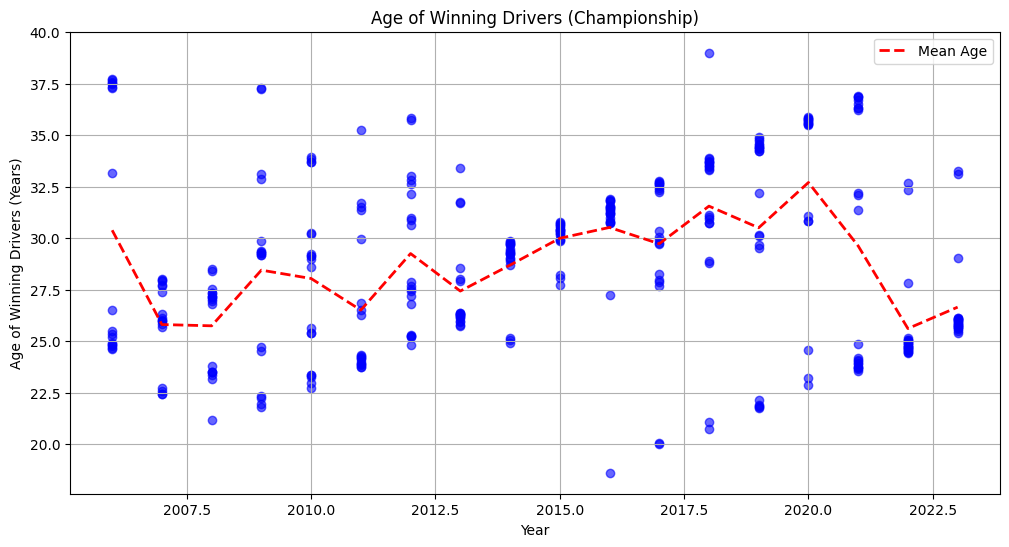

In [43]:
import matplotlib.pyplot as plt

# Filter data for winning drivers
winning_drivers = merged_data[merged_data['winner'] == 1]

# Calculate the age of the winning drivers in years
winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25

# Add a trending mean line
mean_age_per_year = winning_drivers.groupby('year')['age_at_gp_in_years'].mean()

plt.figure(figsize=(12, 6))
plt.scatter(winning_drivers['year'], winning_drivers['age_at_gp_in_years'], color='blue', alpha=0.6)
plt.plot(mean_age_per_year.index, mean_age_per_year.values, color='red', linestyle='--', linewidth=2, label='Mean Age')
plt.title('Age of Winning Drivers (Championship)')
plt.xlabel('Year')
plt.ylabel('Age of Winning Drivers (Years)')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
merged_data.to_csv('data/cleaned_data_EDA.csv', index=False)

### First training

initial prediction to evaluate the model's performance before proceeding with feature engineering and hyperparameter tuning.

Understanding the Problem
Objective: For each race, predict which driver will win (i.e., finish in position 1).
Constraints:
Only one driver can win each race.
Multiple drivers participate in each race.
Classification vs. Regression
Classification Problem:

Involves predicting a discrete class label.
Binary Classification: Predict whether each driver will win (1) or not (0).
Multiclass Classification: Not applicable here since only one driver wins per race.
Regression Problem:

Involves predicting a continuous value.
Predicting Positions: Could predict the finishing position of each driver (1st, 2nd, 3rd, etc.).
Answer: It's Primarily a Classification Problem with a Ranking Component
Classification:

Since the outcome (winning or not) is categorical, it's a classification problem.
However, due to the nature of the problem (only one winner per race), we need to handle it carefully.
Ranking Component:

We need to rank drivers within each race to predict the most likely winner.
This adds a layer of complexity beyond simple binary classification.
How to Proceed
1. Set Up the Problem as a Classification Task
Goal: For each driver in each race, predict the probability of winning.
Target Variable: winner (1 if the driver won the race, 0 otherwise).
2. Address the Unique Challenge
Constraint: Only one driver can win per race.
Implication: Traditional classification might predict multiple winners per race, which isn't realistic.
3. Implement a Per-Race Winner Selection
Solution: For each race, after predicting probabilities, select the driver with the highest probability as the predicted winner.
This ensures that only one driver is predicted as the winner per race.

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Read the data with error handling

data = pd.read_csv('data/cleaned_data_EDA.csv')
print(data.head())


   raceId  year  round  circuitId             GP_name        date circuitRef  \
0      53  2006      1          3  Bahrain Grand Prix  2006-03-12    bahrain   
1      53  2006      1          3  Bahrain Grand Prix  2006-03-12    bahrain   
2      53  2006      1          3  Bahrain Grand Prix  2006-03-12    bahrain   
3      53  2006      1          3  Bahrain Grand Prix  2006-03-12    bahrain   
4      53  2006      1          3  Bahrain Grand Prix  2006-03-12    bahrain   

   country  grid  position  ...  driver_dnf  constructor_dnf  \
0  Bahrain     3         4  ...           0                0   
1  Bahrain     6        15  ...           0                0   
2  Bahrain     4         1  ...           0                0   
3  Bahrain    12         7  ...           0                0   
4  Bahrain     7         6  ...           0                0   

          driver_name age_at_gp_in_days  driver_country  constructor_country  \
0       Jenson Button              9549              U

In [46]:
# Check data types
print(data.dtypes)

raceId                     int64
year                       int64
round                      int64
circuitId                  int64
GP_name                   object
date                      object
circuitRef                object
country                   object
grid                       int64
position                   int64
points                   float64
laps                       int64
dob                       object
constructor_name          object
total_points             float64
championship_position      int64
number_wins                int64
q1                        object
q2                        object
q3                        object
driver_dnf                 int64
constructor_dnf            int64
driver_name               object
age_at_gp_in_days          int64
driver_country            object
constructor_country       object
winner                     int64
q1_seconds               float64
q2_seconds               float64
q3_seconds               float64
dtype: obj

In [47]:
data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'GP_name', 'date', 'circuitRef',
       'country', 'grid', 'position', 'points', 'laps', 'dob',
       'constructor_name', 'total_points', 'championship_position',
       'number_wins', 'q1', 'q2', 'q3', 'driver_dnf', 'constructor_dnf',
       'driver_name', 'age_at_gp_in_days', 'driver_country',
       'constructor_country', 'winner', 'q1_seconds', 'q2_seconds',
       'q3_seconds'],
      dtype='object')

In [76]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')


# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'q2_seconds', 'q3_seconds',
    'total_points', 'championship_position', 'circuitRef', 'round', 
    'number_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'year'

]

target = 'winner'

# Subset the data
df = data[features + ['raceId', target]].copy()


# Define categorical and numerical features
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'q2_seconds', 'q3_seconds','year']
numerical_features_unscaled = [
    'grid', 'total_points', 'championship_position', 'number_wins', 'round'
]

# Split data into training and test sets based on year
train_df = df[df['year'] < 2022].reset_index(drop=True)
test_df = df[df['year'] >= 2022].reset_index(drop=True)

# Prepare training data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data
X_test = test_df[features]
y_test = test_df[target]
race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Function to calculate race-wise accuracy
def calculate_race_wise_accuracy(y_true, y_probs, race_ids, driver_names):
    # Create a DataFrame with the necessary information
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'driver_name': driver_names,
        'winner': y_true,
        'predicted_prob': y_probs
    })

    # Get unique races
    unique_races = results_df['raceId'].unique()
    
    correct_predictions = 0
    total_races = len(unique_races)

    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id]
        # Predict the winner as the driver with the highest predicted probability
        predicted_winner = race_data.loc[race_data['predicted_prob'].idxmax()]
        actual_winner = race_data[race_data['winner'] == 1]
        if not actual_winner.empty:
            actual_winner_name = actual_winner['driver_name'].values[0]
            if predicted_winner['driver_name'] == actual_winner_name:
                correct_predictions += 1
        else:
            # Handle cases where there is no actual winner in the data
            total_races -= 1  # Exclude this race from total count
    if total_races > 0:
        race_wise_accuracy = correct_predictions / total_races
    else:
        race_wise_accuracy = 0
    return race_wise_accuracy

# Create a function to perform cross-validation and calculate mean race-wise accuracy
def cross_validate_race_wise(model, X, y, df, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    race_wise_accuracies = []

    for train_index, val_index in tscv.split(X):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]
        df_val_fold = df.iloc[val_index].reset_index(drop=True)
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities on validation set
        y_probs = pipeline.predict_proba(X_val_fold)[:, 1]
        
        # Calculate race-wise accuracy
        race_wise_acc = calculate_race_wise_accuracy(
            y_true=y_val_fold.reset_index(drop=True),
            y_probs=y_probs,
            race_ids=df_val_fold['raceId'],
            driver_names=df_val_fold['driver_name']
        )
        race_wise_accuracies.append(race_wise_acc)

    mean_race_wise_accuracy = np.mean(race_wise_accuracies)
    return mean_race_wise_accuracy

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Adjust scale_pos_weight for XGBoost
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
models['XGBoost'].set_params(scale_pos_weight=ratio)

# Store results
results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    # Cross-validation on training data
    mean_race_wise_accuracy = cross_validate_race_wise(model, X_train, y_train, train_df, n_splits=5)
    
    # Fit the model on the entire training data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on test data
    y_probs_test = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate race-wise accuracy on test set
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Store the results
    results[model_name] = {
        'mean_race_wise_accuracy_train': mean_race_wise_accuracy,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }

# Print summary of results
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")


Processing Logistic Regression...
Processing Random Forest...
Processing SVM...
Processing XGBoost...

Summary of Results:
Logistic Regression:
 - Mean Race-wise Accuracy on training data: 0.5361
 - Race-wise Accuracy on test data: 0.7955

Random Forest:
 - Mean Race-wise Accuracy on training data: 0.5432
 - Race-wise Accuracy on test data: 0.7273

SVM:
 - Mean Race-wise Accuracy on training data: 0.5706
 - Race-wise Accuracy on test data: 0.5000

XGBoost:
 - Mean Race-wise Accuracy on training data: 0.5699
 - Race-wise Accuracy on test data: 0.6364



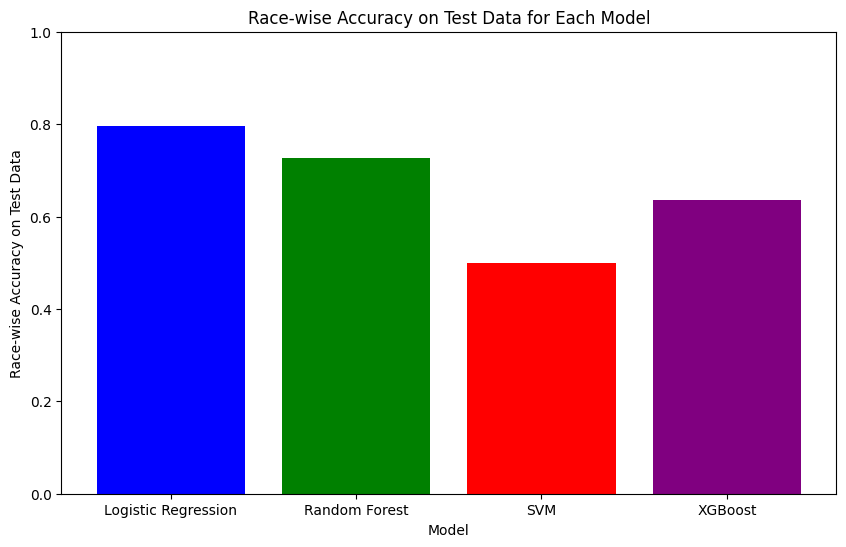

In [77]:
import matplotlib.pyplot as plt

# Extract race-wise accuracy on test data for each model
model_names = list(results.keys())
race_wise_accuracies = [results[model]['race_wise_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, race_wise_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Race-wise Accuracy on Test Data')
plt.title('Race-wise Accuracy on Test Data for Each Model')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

### FEATURE ENGINEERING

new features: 
- constructor reliability
- driver reliability
- driver home race
- constructor hom race
- average performance last 3 races

In [78]:
def calculate_constructor_reliability(df):
    # Sort data by date
    df = df.sort_values(by=['constructor_name', 'date'])
    df['constructor_reliability'] = 0.0
    
    constructors = df['constructor_name'].unique()
    
    for constructor in constructors:
        constructor_data = df[df['constructor_name'] == constructor]
        reliability_list = []
        finished_races = 0
        total_races = 0
        
        for idx, row in constructor_data.iterrows():
            # Only consider past races
            past_races = constructor_data[constructor_data['date'] < row['date']]
            total_races = past_races['raceId'].nunique()
            finished_races = past_races[past_races['position'] > 0]['raceId'].nunique()
            reliability = finished_races / total_races if total_races > 0 else 1.0  # Assume reliability of 1.0 if no past races
            reliability_list.append(reliability)
        
        df.loc[constructor_data.index, 'constructor_reliability'] = reliability_list
    
    return df

def calculate_driver_reliability(df):
    # Sort data by date
    df = df.sort_values(by=['driver_name', 'date'])
    df['driver_reliability'] = 0.0
    
    drivers = df['driver_name'].unique()
    
    for driver in drivers:
        driver_data = df[df['driver_name'] == driver]
        reliability_list = []
        finished_races = 0
        total_races = 0
        
        for idx, row in driver_data.iterrows():
            # Only consider past races
            past_races = driver_data[driver_data['date'] < row['date']]
            total_races = past_races['raceId'].nunique()
            finished_races = past_races[past_races['position'] > 0]['raceId'].nunique()
            reliability = finished_races / total_races if total_races > 0 else 1.0  # Assume reliability of 1.0 if no past races
            reliability_list.append(reliability)
        
        df.loc[driver_data.index, 'driver_reliability'] = reliability_list
    
    return df

def add_driver_home_race(df):
    df['driver_home_race'] = (df['driver_country'] == df['country']).astype(int)
    return df

def add_constructor_home_race(df):
    df['constructor_home_race'] = (df['constructor_country'] == df['country']).astype(int)
    return df


In [79]:
# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')

data['date'] = pd.to_datetime(data['date'])


# Implement the new features
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)


# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'q2_seconds', 'q3_seconds',
    'total_points', 'championship_position', 'circuitRef', 'round', 
    'number_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'year',
    'constructor_reliability', 'driver_reliability', 'driver_home_race']

target = 'winner'

# Subset the data
df = data[features + ['raceId', target]].copy()


# Define categorical and numerical features
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'q2_seconds', 'q3_seconds','year']
numerical_features_unscaled = ['grid', 'total_points', 'championship_position', 'number_wins', 'round', 
                               'constructor_reliability', 'driver_reliability', 'driver_home_race']

# Split data into training and test sets based on year
train_df = df[df['year'] < 2021].reset_index(drop=True)
test_df = df[df['year'] >= 2021].reset_index(drop=True)

# Prepare training data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data
X_test = test_df[features]
y_test = test_df[target]
race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Store results
results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    # Cross-validation on training data
    mean_race_wise_accuracy = cross_validate_race_wise(model, X_train, y_train, train_df, n_splits=5)
    
    # Fit the model on the entire training data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on test data
    y_probs_test = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate race-wise accuracy on test set
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Store the results
    results[model_name] = {
        'mean_race_wise_accuracy_train': mean_race_wise_accuracy,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }

# Print summary of results
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")

Processing Logistic Regression...
Processing Random Forest...
Processing SVM...
Processing XGBoost...

Summary of Results:
Logistic Regression:
 - Mean Race-wise Accuracy on training data: 0.8491
 - Race-wise Accuracy on test data: 0.7424

Random Forest:
 - Mean Race-wise Accuracy on training data: 0.8735
 - Race-wise Accuracy on test data: 0.6061

SVM:
 - Mean Race-wise Accuracy on training data: 0.8270
 - Race-wise Accuracy on test data: 0.5455

XGBoost:
 - Mean Race-wise Accuracy on training data: 0.8603
 - Race-wise Accuracy on test data: 0.6364



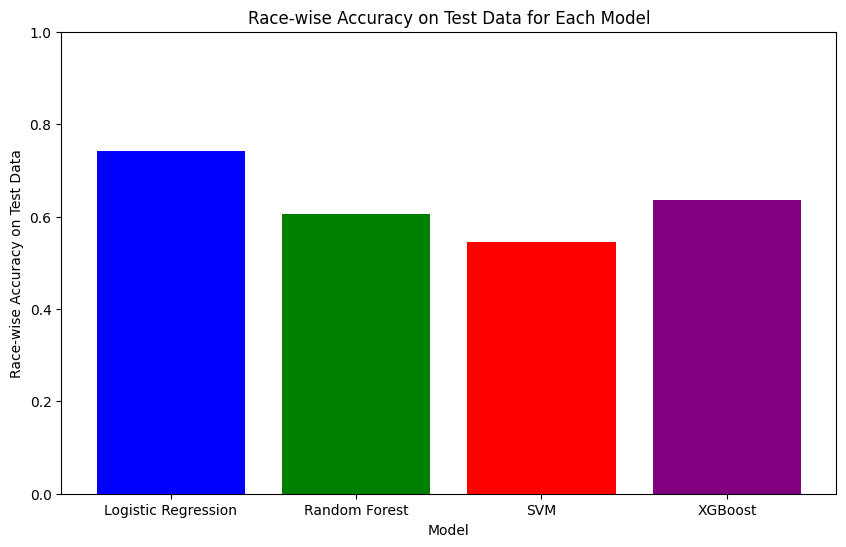

In [80]:
import matplotlib.pyplot as plt

# Extract race-wise accuracy on test data for each model
model_names = list(results.keys())
race_wise_accuracies = [results[model]['race_wise_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, race_wise_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Race-wise Accuracy on Test Data')
plt.title('Race-wise Accuracy on Test Data for Each Model')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()